In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv
import matplotlib.pyplot as plt

In [2]:
# Define the Graph Attention Network (GAT) model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=16, dropout_rate=0.2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        # The output dimension of the second layer is not multiplied by the number of heads
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout_rate)

        self.conv3 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout_rate)

        self.dropout = dropout_rate

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.conv1(x, edge_index))  # First layer with attention
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)  # Second layer without activation
        return F.log_softmax(x, dim=1)

In [3]:
# Define the training function
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Define the testing function
def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = pred[data.test_mask] == data.y[data.test_mask]
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
    return test_acc

In [4]:
# Load the CORA dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

c:\Users\maert\anaconda3\envs\bachelor\Lib\site-packages\torch_geometric\data\dataset.py:238: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and torch.load(f

In [5]:
# Setup for training the GAT model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(in_channels=dataset.num_features, hidden_channels=32, out_channels=dataset.num_classes, heads=4).to(device)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 1000
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    loss = train(model, optimizer, data)
    train_losses.append(loss)
    
    if epoch % 10 == 0:
        test_acc = test(model, data)
        test_accuracies.append(1-test_acc)
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')


Epoch 0, Loss: 4.8687, Test Accuracy: 0.0080
Epoch 10, Loss: 4.6593, Test Accuracy: 0.1950
Epoch 20, Loss: 4.2318, Test Accuracy: 0.2480
Epoch 30, Loss: 3.7028, Test Accuracy: 0.2510
Epoch 40, Loss: 2.9420, Test Accuracy: 0.2400
Epoch 50, Loss: 2.2706, Test Accuracy: 0.2900
Epoch 60, Loss: 1.8569, Test Accuracy: 0.6460
Epoch 70, Loss: 1.5677, Test Accuracy: 0.7640
Epoch 80, Loss: 1.4338, Test Accuracy: 0.7430
Epoch 90, Loss: 1.3177, Test Accuracy: 0.7510
Epoch 100, Loss: 1.2174, Test Accuracy: 0.7740
Epoch 110, Loss: 1.1214, Test Accuracy: 0.7860
Epoch 120, Loss: 1.1538, Test Accuracy: 0.7820
Epoch 130, Loss: 0.9897, Test Accuracy: 0.7840
Epoch 140, Loss: 0.8362, Test Accuracy: 0.7980
Epoch 150, Loss: 0.8321, Test Accuracy: 0.7920
Epoch 160, Loss: 0.8009, Test Accuracy: 0.7970
Epoch 170, Loss: 0.7298, Test Accuracy: 0.8120
Epoch 180, Loss: 0.5798, Test Accuracy: 0.8050
Epoch 190, Loss: 0.5600, Test Accuracy: 0.8000
Epoch 200, Loss: 0.5695, Test Accuracy: 0.8030
Epoch 210, Loss: 0.4890,

In [13]:
# List of different hidden channel sizes to try
#hidden_channel_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
hidden_channel_sizes = 128
train_losses = []
test_loss = []

# Training loop for different hidden channel sizes
for hidden_channels in range(2,hidden_channel_sizes+1,2):
    print(f'Training with hidden_channels={hidden_channels}')
    
    # Setup for training the GAT model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GAT(in_channels=dataset.num_features, hidden_channels=hidden_channels, out_channels=dataset.num_classes, heads=4).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    num_epochs = 2000
    lowest_train_loss = float('inf')
    lowest_test_loss = float('inf')

    for epoch in range(num_epochs):
        loss = train(model, optimizer, data)
        if loss < lowest_train_loss:
            lowest_train_loss = loss
            

        if epoch % 10 == 0:
            test_acc = test(model, data)
            if (1-test_acc) < lowest_test_loss:
                lowest_test_loss = (1-test_acc)
            #print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')
    print(f'Lowest train loss: {lowest_train_loss:.4f}, Lowest test loss: {lowest_test_loss:.4f}')
    train_losses.append(lowest_train_loss)
    test_loss.append(lowest_test_loss)

Training with hidden_channels=2
Lowest train loss: 0.0239, Lowest test loss: 0.1900
Training with hidden_channels=4
Lowest train loss: 0.0175, Lowest test loss: 0.1760
Training with hidden_channels=6
Lowest train loss: 0.0126, Lowest test loss: 0.1680
Training with hidden_channels=8
Lowest train loss: 0.0084, Lowest test loss: 0.1850
Training with hidden_channels=10
Lowest train loss: 0.0128, Lowest test loss: 0.1760
Training with hidden_channels=12
Lowest train loss: 0.0112, Lowest test loss: 0.1840
Training with hidden_channels=14
Lowest train loss: 0.0114, Lowest test loss: 0.1900
Training with hidden_channels=16
Lowest train loss: 0.0106, Lowest test loss: 0.1750
Training with hidden_channels=18
Lowest train loss: 0.0090, Lowest test loss: 0.1750
Training with hidden_channels=20
Lowest train loss: 0.0104, Lowest test loss: 0.1750
Training with hidden_channels=22
Lowest train loss: 0.0105, Lowest test loss: 0.1780
Training with hidden_channels=24
Lowest train loss: 0.0110, Lowest te

KeyboardInterrupt: 

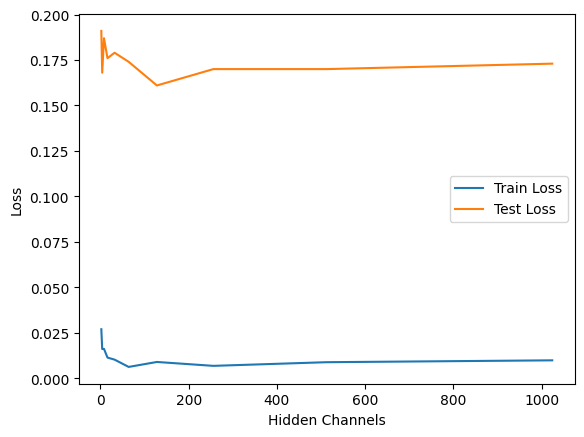

In [12]:
plt.plot(hidden_channel_sizes, train_losses, label='Train Loss')
plt.plot(hidden_channel_sizes, test_loss, label='Test Loss')
plt.xlabel('Hidden Channels')
plt.ylabel('Loss')
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (3,) and (408,)

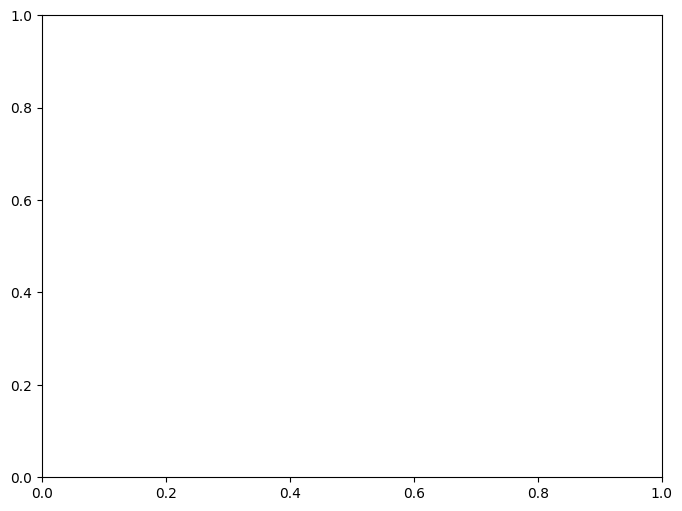

In [9]:
# Plot the loss over time
plt.figure(figsize=(8,6))
plt.plot(hidden_channel_sizes, train_losses, label="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Plot the test accuracy over time (every 10 epochs)
plt.figure(figsize=(8,6))
plt.plot(range(0, hidden_channel_sizes), test_accuracies, label="Test Accuracy", marker="o")
plt.title("Test Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.grid(True)
plt.show()

In [41]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv

# Load the Cora dataset
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
data = dataset[0]

def personalized_pagerank(adj_matrix, alpha=0.85, eps=1e-6):
    n = adj_matrix.size(0)
    
    # Convert sparse tensor to dense tensor
    adj_matrix_dense = adj_matrix.to_dense()
    
    # Normalize adjacency matrix (row-wise)
    row_sum = adj_matrix_dense.sum(dim=1, keepdim=True)  # Shape is [n, 1]
    
    # Avoid division by zero by adding a small value where row_sum is zero
    row_sum = row_sum + eps
    
    adj_matrix_normalized = adj_matrix_dense / row_sum  # Element-wise division

    # Compute Personalized PageRank (PPR)
    ppr_matrix = torch.inverse(torch.eye(n).to(adj_matrix.device) - alpha * adj_matrix_normalized) * (1 - alpha)
    
    return ppr_matrix


# Define a modified GAT model that incorporates PPR into the forward pass
class GATWithPPR(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, alpha=0.85):
        super(GATWithPPR, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.2)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.2)
        self.alpha = alpha  # Teleportation factor for PPR

    def forward(self, x, edge_index):
        # Convert edge_index to adjacency matrix
        n = x.size(0)
        adj_matrix = torch.sparse_coo_tensor(edge_index, torch.ones(edge_index.shape[1]).to(x.device), (n, n)).to(x.device)
        
        # Compute PPR matrix
        ppr_matrix = personalized_pagerank(adj_matrix, alpha=self.alpha)

        # Modify input features using PPR
        x_ppr = torch.mm(ppr_matrix, x)

        # GAT layers
        x = F.dropout(x_ppr, p=0.2, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=-1)

# Instantiate the GATWithPPR model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATWithPPR(dataset.num_node_features, 8, dataset.num_classes).to(device)
data = data.to(device)
epochs = 2000

# Set up the optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training and testing functions
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    acc = int(correct) / int(data.test_mask.sum())
    return acc

test_accs = []

# Train the model
for epoch in range(epochs):
    train()
    acc = test()

    test_accs.append(acc)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Test Accuracy: {acc:.4f}')


Epoch: 000, Test Accuracy: 0.2010
Epoch: 100, Test Accuracy: 0.3140
Epoch: 200, Test Accuracy: 0.4520
Epoch: 300, Test Accuracy: 0.4860
Epoch: 400, Test Accuracy: 0.2980
Epoch: 500, Test Accuracy: 0.5100
Epoch: 600, Test Accuracy: 0.6160
Epoch: 700, Test Accuracy: 0.5920
Epoch: 800, Test Accuracy: 0.5660
Epoch: 900, Test Accuracy: 0.7030
Epoch: 1000, Test Accuracy: 0.7060
Epoch: 1100, Test Accuracy: 0.5930
Epoch: 1200, Test Accuracy: 0.6660
Epoch: 1300, Test Accuracy: 0.7190
Epoch: 1400, Test Accuracy: 0.7650
Epoch: 1500, Test Accuracy: 0.7520
Epoch: 1600, Test Accuracy: 0.7630
Epoch: 1700, Test Accuracy: 0.7540
Epoch: 1800, Test Accuracy: 0.7540
Epoch: 1900, Test Accuracy: 0.7450


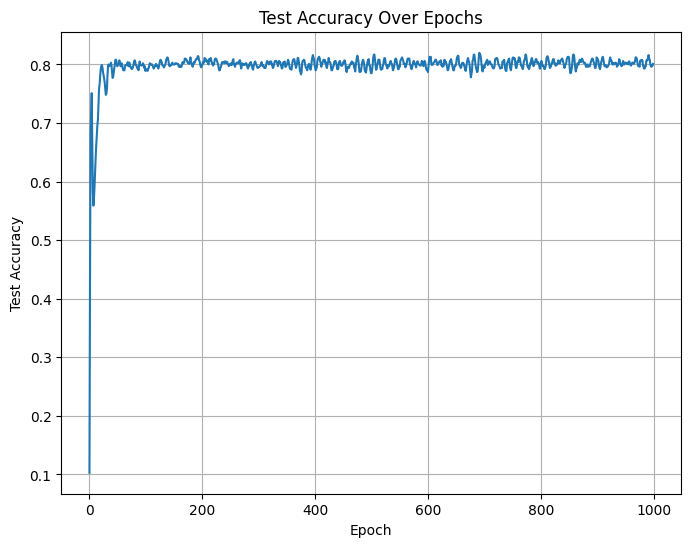

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(range(epochs), test_accs, label="GAT")
plt.title("Test Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()